In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow as tf
import re
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, Dense, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image


In [2]:
import tensorflow as tf

In [3]:
tf.__version__    #2.16.1

'2.13.1'

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

base_path  = './data/'

categories = {
    0: 'battery', 1: 'clothes', 2: 'glass', 3: 'metal', 
    4: 'organic', 5: 'paper', 6: 'plastic', 7: 'shoes'
}

In [4]:
df = pd.read_csv('./data/waste_classification.csv')
print('Number of elements =', len(df))

Number of elements = 23871


In [5]:
df.head()

,filename,category,category_name
0,clothes/clothes4968.jpg,1,clothes
1,organic/organic_011260_photo.jpg,4,organic
2,plastic/R_597.jpg,6,plastic
3,clothes/clothes4851.jpg,1,clothes
4,organic/organic_001994_photo.jpg,4,organic


clothes/clothes4001.jpg


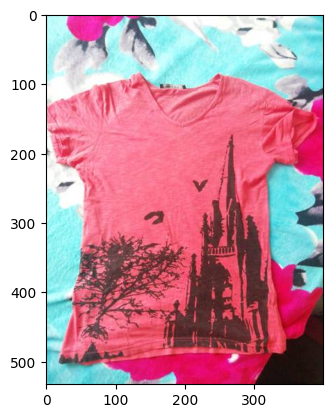

In [8]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

In [9]:
len(categories)

8

In [10]:
mobilenetv2_layer = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    weights='imagenet',
    pooling='avg'
)

# We don't want to train the imported weights
mobilenetv2_layer.trainable = True

In [11]:
len(mobilenetv2_layer.layers)

155

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenetv2_layer.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenetv2_layer.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [13]:
# Create a custom layer to apply preprocessing
def mobilenetv2_preprocessing(img):
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

model_input = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
x = Lambda(mobilenetv2_preprocessing)(model_input)
x = mobilenetv2_layer(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)
output = Dense(len(categories), activation='softmax')(x)
model = Model(inputs=model_input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                             

In [14]:
# Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# Split the data into train, validation, and test sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('Train size =', total_train, 'Validate size =', total_validate, 'Test size =', test_df.shape[0])

Train size = 19096 Validate size = 2387 Test size = 2388


In [15]:
batch_size = 64
EPOCHS = 20

In [16]:
# Create data pipelines using tf.data API
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19096 validated image filenames belonging to 8 classes.
Found 2387 validated image filenames belonging to 8 classes.


In [17]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
)

Epoch 1/20
298/298 [==============================] - 395s 1s/step - loss: 0.4723 - categorical_accuracy: 0.8453 - val_loss: 5.8912 - val_categorical_accuracy: 0.5650
Epoch 2/20
298/298 [==============================] - 368s 1s/step - loss: 0.3252 - categorical_accuracy: 0.8971 - val_loss: 3.7427 - val_categorical_accuracy: 0.6178
Epoch 3/20
298/298 [==============================] - 405s 1s/step - loss: 0.2782 - categorical_accuracy: 0.9086 - val_loss: 3.0899 - val_categorical_accuracy: 0.6309
Epoch 4/20
298/298 [==============================] - 378s 1s/step - loss: 0.2446 - categorical_accuracy: 0.9181 - val_loss: 1.8687 - val_categorical_accuracy: 0.7749
Epoch 5/20
298/298 [==============================] - 396s 1s/step - loss: 0.2198 - categorical_accuracy: 0.9274 - val_loss: 0.6353 - val_categorical_accuracy: 0.8885
Epoch 6/20
298/298 [==============================] - 378s 1s/step - loss: 0.2031 - categorical_accuracy: 0.9331 - val_loss: 1.3071 - val_categorical_accuracy: 0.820

In [18]:
model.save("models/mobilenetv2/model03_batch_20")

INFO:tensorflow:Assets written to: models/mobilenetv2/model03_batch_20\assets


INFO:tensorflow:Assets written to: models/mobilenetv2/model03_batch_20\assets


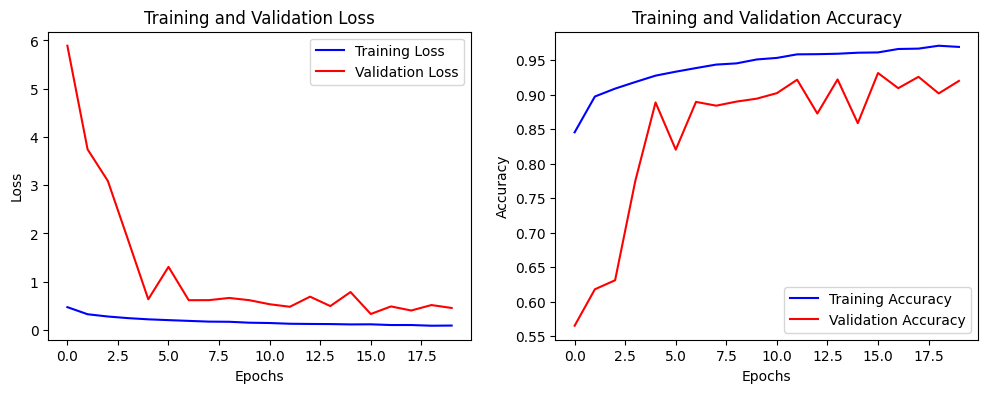

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('./output/mobilenetv2_model03_batch_20.png')
plt.show()

In [20]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Accuracy on test set =', round((accuracy * 100), 2), '%')

Found 2388 validated image filenames belonging to 8 classes.
2388/2388 [==============================] - 38s 16ms/step - loss: 0.4426 - categorical_accuracy: 0.9209
Accuracy on test set = 92.09 %


In [21]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated its own dictionary and it has assigned different numbers to our categories, and the predictions made by the model
# will be made using the generator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v, k) for k, v in gen_label_map.items())
print(gen_label_map)

# Get the model's predictions for the test set
preds = model.predict(test_generator, steps=nb_samples)

# Get the category with the highest predicted probability; the prediction is only the category's number and not the name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas DataFrame to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

{0: 'battery', 1: 'clothes', 2: 'glass', 3: 'metal', 4: 'organic', 5: 'paper', 6: 'plastic', 7: 'shoes'}
2388/2388 [==============================] - 39s 16ms/step
              precision    recall  f1-score   support

     battery       0.89      0.98      0.94       118
     clothes       0.95      0.99      0.97       550
       glass       0.89      0.92      0.91       246
       metal       0.83      0.83      0.83       174
     organic       0.97      0.90      0.93       582
       paper       0.92      0.94      0.93       236
     plastic       0.87      0.84      0.85       297
       shoes       0.94      0.92      0.93       185

    accuracy                           0.92      2388
   macro avg       0.91      0.92      0.91      2388
weighted avg       0.92      0.92      0.92      2388



organic/organic_007844_photo.jpg
1/1 [==============================] - 1s 633ms/step
[[2.3714519e-15 6.3572444e-13 2.9785510e-10 3.8887236e-09 9.9999988e-01
  5.1609415e-11 1.5797973e-07 2.7025401e-11]]
4
organic


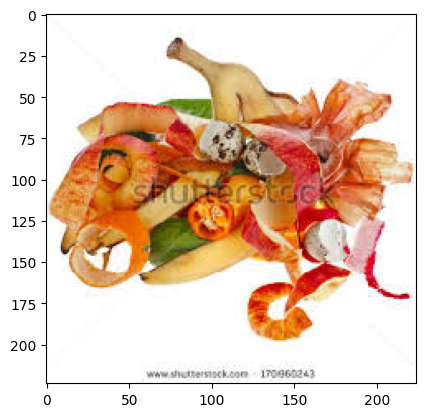

In [22]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
img_path = base_path +sample['filename']
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

print(sample['filename'])
plt.imshow(img)

preds = model.predict(x)
print(preds)

preds_max=np.argmax(preds)
print(preds_max)
print(categories[preds_max])

In [23]:
history2 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
)

Epoch 1/5
298/298 [==============================] - 522s 2s/step - loss: 0.0866 - categorical_accuracy: 0.9706 - val_loss: 0.5372 - val_categorical_accuracy: 0.9168
Epoch 2/5
298/298 [==============================] - 515s 2s/step - loss: 0.0871 - categorical_accuracy: 0.9720 - val_loss: 0.4560 - val_categorical_accuracy: 0.9231
Epoch 3/5
298/298 [==============================] - 565s 2s/step - loss: 0.0802 - categorical_accuracy: 0.9732 - val_loss: 0.4150 - val_categorical_accuracy: 0.9312
Epoch 4/5
298/298 [==============================] - 511s 2s/step - loss: 0.0738 - categorical_accuracy: 0.9749 - val_loss: 0.4699 - val_categorical_accuracy: 0.9206
Epoch 5/5
298/298 [==============================] - 484s 2s/step - loss: 0.0688 - categorical_accuracy: 0.9771 - val_loss: 0.3760 - val_categorical_accuracy: 0.9333


In [24]:
model.save("models/mobilenetv2/model03_batch_25")

INFO:tensorflow:Assets written to: models/mobilenetv2/model03_batch_25\assets


INFO:tensorflow:Assets written to: models/mobilenetv2/model03_batch_25\assets


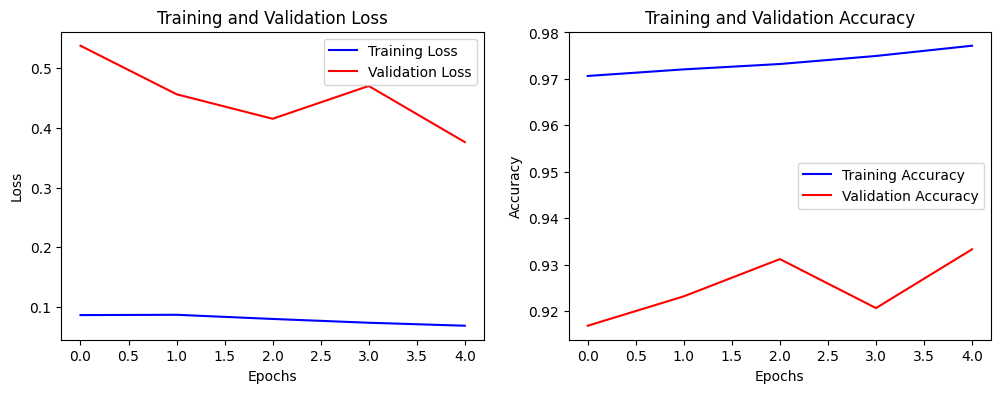

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history2.history['categorical_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history2.history['val_categorical_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('./output/mobilenetv2_model03_batch_25.png')
plt.show()

In [26]:
_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Accuracy on test set =', round((accuracy * 100), 2), '%')

2388/2388 [==============================] - 47s 20ms/step - loss: 0.3602 - categorical_accuracy: 0.9393
Accuracy on test set = 93.93 %


In [27]:
# Get the model's predictions for the test set
preds = model.predict(test_generator, steps=nb_samples)

# Get the category with the highest predicted probability; the prediction is only the category's number and not the name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas DataFrame to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

2388/2388 [==============================] - 48s 20ms/step
              precision    recall  f1-score   support

     battery       0.88      0.99      0.93       118
     clothes       0.99      0.98      0.98       550
       glass       0.89      0.95      0.92       246
       metal       0.88      0.87      0.88       174
     organic       0.95      0.95      0.95       582
       paper       0.99      0.89      0.93       236
     plastic       0.91      0.88      0.90       297
       shoes       0.93      0.95      0.94       185

    accuracy                           0.94      2388
   macro avg       0.93      0.93      0.93      2388
weighted avg       0.94      0.94      0.94      2388



In [68]:
history_loss =[*history.history['loss'], *history2.history['loss']]
history_val_loss = [*history.history['val_loss'], *history2.history['val_loss']]
history_categorical_accuracy = [*history.history['categorical_accuracy'], *history2.history['categorical_accuracy']]
history_val_categorical_accuracy = [*history.history['val_categorical_accuracy'], *history2.history['val_categorical_accuracy']]

In [69]:
history_loss

[0.47226160764694214,
 0.32519248127937317,
 0.2781542241573334,
 0.24462349712848663,
 0.21978819370269775,
 0.20313002169132233,
 0.18759967386722565,
 0.17228840291500092,
 0.1689261943101883,
 0.14979596436023712,
 0.14323168992996216,
 0.12804366648197174,
 0.12385918945074081,
 0.12153726071119308,
 0.11434582620859146,
 0.11644754558801651,
 0.10144898295402527,
 0.10158345103263855,
 0.0872228667140007,
 0.09088786691427231,
 0.08659784495830536,
 0.0871208906173706,
 0.08015282452106476,
 0.07381223887205124,
 0.06882476806640625]

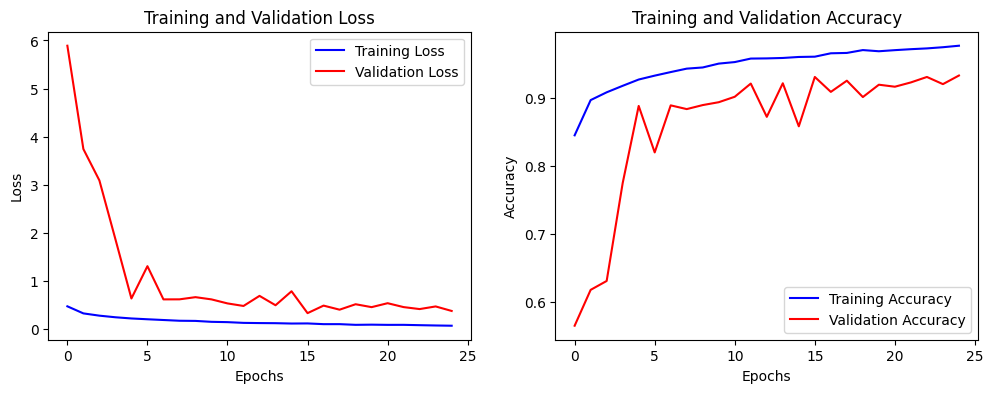

In [70]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Training Loss', color='blue')
plt.plot(history_val_loss, label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_categorical_accuracy, label='Training Accuracy', color='blue')
plt.plot(history_val_categorical_accuracy, label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('./output/mobilenetv2_model03_batch_25_all.png')
plt.show()

In [29]:
his=history.history
his

{'loss': [0.47226160764694214,
  0.32519248127937317,
  0.2781542241573334,
  0.24462349712848663,
  0.21978819370269775,
  0.20313002169132233,
  0.18759967386722565,
  0.17228840291500092,
  0.1689261943101883,
  0.14979596436023712,
  0.14323168992996216,
  0.12804366648197174,
  0.12385918945074081,
  0.12153726071119308,
  0.11434582620859146,
  0.11644754558801651,
  0.10144898295402527,
  0.10158345103263855,
  0.0872228667140007,
  0.09088786691427231],
 'categorical_accuracy': [0.8452606201171875,
  0.8971206545829773,
  0.9085750579833984,
  0.9181378483772278,
  0.9273854494094849,
  0.9331126809120178,
  0.9383669495582581,
  0.943411111831665,
  0.9451450109481812,
  0.9508196711540222,
  0.9530790448188782,
  0.9582282304763794,
  0.9584909677505493,
  0.9591214656829834,
  0.9605926871299744,
  0.9610130190849304,
  0.9660046100616455,
  0.9665300250053406,
  0.9707335233688354,
  0.9689995646476746],
 'val_loss': [5.891206741333008,
  3.7426536083221436,
  3.08994388580

In [71]:
history3 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
)

Epoch 1/5
298/298 [==============================] - 513s 2s/step - loss: 0.0706 - categorical_accuracy: 0.9759 - val_loss: 0.4669 - val_categorical_accuracy: 0.9202
Epoch 2/5
298/298 [==============================] - 497s 2s/step - loss: 0.0745 - categorical_accuracy: 0.9746 - val_loss: 0.4481 - val_categorical_accuracy: 0.9113
Epoch 3/5
298/298 [==============================] - 487s 2s/step - loss: 0.0658 - categorical_accuracy: 0.9775 - val_loss: 0.5119 - val_categorical_accuracy: 0.9092
Epoch 4/5
298/298 [==============================] - 512s 2s/step - loss: 0.0648 - categorical_accuracy: 0.9788 - val_loss: 0.5547 - val_categorical_accuracy: 0.9160
Epoch 5/5
298/298 [==============================] - 530s 2s/step - loss: 0.0711 - categorical_accuracy: 0.9774 - val_loss: 0.5010 - val_categorical_accuracy: 0.9151


In [72]:
model.save("models/mobilenetv2/model03_batch_30")

INFO:tensorflow:Assets written to: models/mobilenetv2/model03_batch_30\assets


INFO:tensorflow:Assets written to: models/mobilenetv2/model03_batch_30\assets


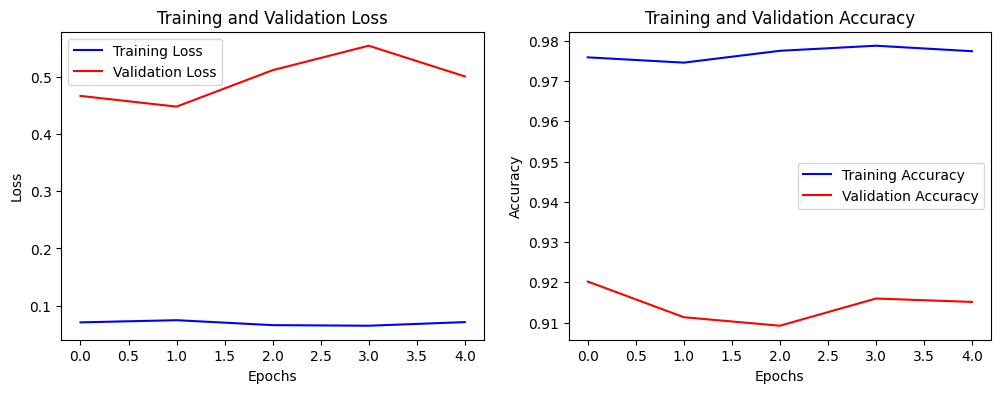

In [73]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss', color='blue')
plt.plot(history3.history['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history3.history['categorical_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history3.history['val_categorical_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('./output/mobilenetv2_model03_batch_30.png')
plt.show()

In [74]:
history_loss =[*history_loss, *history3.history['loss']]
history_val_loss = [*history_val_loss, *history3.history['val_loss']]
history_categorical_accuracy = [*history_categorical_accuracy, *history3.history['categorical_accuracy']]
history_val_categorical_accuracy = [*history_val_categorical_accuracy, *history3.history['val_categorical_accuracy']]

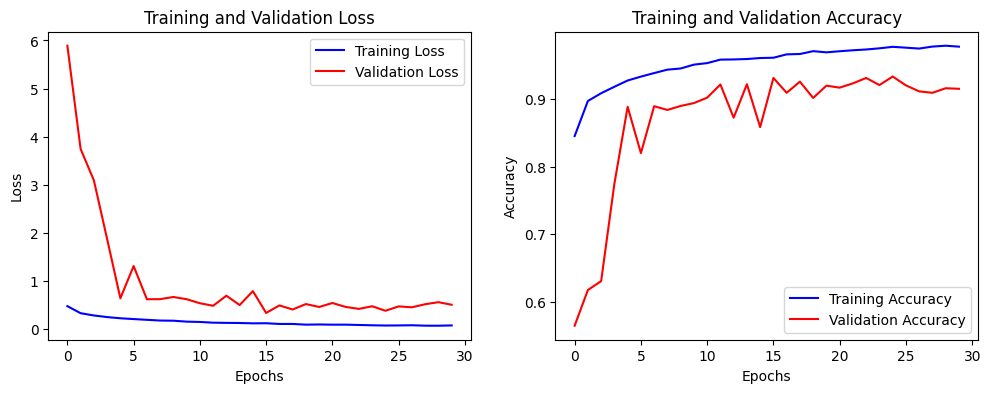

In [75]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Training Loss', color='blue')
plt.plot(history_val_loss, label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_categorical_accuracy, label='Training Accuracy', color='blue')
plt.plot(history_val_categorical_accuracy, label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('./output/mobilenetv2_model03_batch_30_all.png')
plt.show()

In [76]:
_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Accuracy on test set =', round((accuracy * 100), 2), '%')

2388/2388 [==============================] - 42s 18ms/step - loss: 0.5189 - categorical_accuracy: 0.9200
Accuracy on test set = 92.0 %


In [77]:
# Get the model's predictions for the test set
preds = model.predict(test_generator, steps=nb_samples)

# Get the category with the highest predicted probability; the prediction is only the category's number and not the name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas DataFrame to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

2388/2388 [==============================] - 46s 19ms/step
              precision    recall  f1-score   support

     battery       0.99      0.81      0.89       118
     clothes       0.96      0.99      0.97       550
       glass       0.84      0.93      0.88       246
       metal       0.80      0.89      0.84       174
     organic       0.93      0.97      0.95       582
       paper       0.95      0.88      0.91       236
     plastic       0.91      0.78      0.84       297
       shoes       0.93      0.94      0.93       185

    accuracy                           0.92      2388
   macro avg       0.91      0.90      0.90      2388
weighted avg       0.92      0.92      0.92      2388

